In [1]:
import sys
import os
from dotenv import load_dotenv
load_dotenv()
pyAPES_main_folder = os.getenv('pyAPES_main_folder')
sys.path.append(pyAPES_main_folder)

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D

import numpy as np
from pyAPES.utils.iotools import read_forcing
from pyAPES.soil.soil import Soil_1D
from pyAPES.canopy.forestfloor import ForestFloor
from pyAPES.parameters.mlm_parameters import gpara, cpara, spara # model configuration, canopy parameters, soil parameters
from pyAPES.utils.constants import WATER_DENSITY

import warnings
# Ignore FutureWarning messages globally
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [2]:
# Creating ForestFloor
forestfloor = ForestFloor(cpara['forestfloor'])

# Creating Soil_1D
soil = Soil_1D(spara)

# Manipulating the params to correspond to those of Degerö
gpara['forc_filename'] = f'{pyAPES_main_folder}/forcing/Degero/Degero_forcing_2014-2016.dat'
gpara['start_time'] = '2014-09-01'
gpara['end_time'] = '2015-09-01'

In [3]:
# Reading the forcing file
forcing = read_forcing(
    forcing_file=gpara['forc_filename'],
    start_time=gpara['start_time'],
    end_time=gpara['end_time'],
    dt=gpara['dt']
)

forcing['Prec_liquid'] = forcing['Prec'].where(forcing['Tair'] > 1, 0)
forcing['Prec_ice'] = forcing['Prec'].where(forcing['Tair'] <= 1, 0)

In [4]:
# Looping over the forcing file, running forestfloor and soil models for each timestep and saving the results
results_df = pd.DataFrame()

# Number of soil layers
n_layers = len(soil.heat.T)  # or len(s_states['temperature']) at first timestep
# Number of timesteps
n_times = len(forcing)

for index, row in forcing.iterrows():

    ###### Inputs for forestfloor (based on how they are used in mlm_canopy.py)
    ff_forcing = {  # Reset the dictionary for each iteration
        'precipitation_rain': row['Prec_liquid'], # kg m-2 s-1
        'precipitation_snow': row['Prec_ice'], # kg m-2 s-1
        'wind_speed': row['U'], # m/s
        'par': row['diffPar'] + row['dirPar'],  # Total PAR [W m-2]
        'nir': row['diffNir'] + row['dirNir'],  # Total NIR [W m-2]
        'lw_dn': row['LWin'],  # Longwave downward radiation [W m-2]
        'h2o': row['H2O'] / 1000,  # H2O [mol mol-1]
        'co2': row['CO2'] * 1e6,  # Convert mol mol-1 to ppm
        'air_temperature': row['Tair'],  # Air temperature [degC]
        'air_pressure': row['P'],  # Air pressure [Pa]
        'soil_temperature': soil.heat.T[0], # Soil temperature [degC]
        'soil_water_potential': soil.water.h[0],
        'soil_volumetric_water': soil.heat.Wliq[0],
        'soil_volumetric_air': soil.heat.Wair[0],
        'soil_pond_storage': soil.water.h_pond
    }
    ff_params = {
        'soil_thermal_conductivity': soil.heat.thermal_conductivity[0],
        'soil_hydraulic_conductivity': soil.water.Kvsat[0],
        'soil_depth': soil.grid['dz'][0],
        'reference_height': 18.0,
    }
    ff_controls = {
        'energy_balance': True,
        'logger_info': 'test',
    }
    # --- solve forestfloor
    ff_fluxes, ff_states, gt_results = forestfloor.run(
                dt=gpara['dt'],
                forcing=ff_forcing,
                parameters=ff_params,
                controls=ff_controls
                )
    
    # --- update forestfloor
    forestfloor.update()

    ###### Inputs for soil (based on how they are used in pyAPES_MLM.py)
    s_forcing = {
        'potential_infiltration': ff_fluxes['throughfall'] / WATER_DENSITY,
        'potential_evaporation': (ff_fluxes['soil_evaporation'] + ff_fluxes['capillary_rise']) / WATER_DENSITY,
        'pond_recharge': ff_fluxes['pond_recharge'] / WATER_DENSITY,
        'atmospheric_pressure_head': -1.0E6, # [m]
        'ground_heat_flux': -ff_fluxes['ground_heat'],
        'date': index
    }
    
    s_fluxes, s_states = soil.run(
                dt=gpara['dt'],
                forcing=s_forcing,
                )
    
    # --- update soil
    s_states.update(s_fluxes)
    
    # Combine results into a single dictionary with all values as floats
    combined_results = {
        'time': index,  # Use the time index from the forcing DataFrame
        **{f'gt_{key}': value[0] for key, value in gt_results.items()}, 
        **{f'ff_{key}': value for key, value in ff_states.items()},
        **{f'ff_{key}': value for key, value in ff_fluxes.items()},
        **{f'soil_{key}': value.mean() if hasattr(value, 'mean') else value for key, value in s_states.items()},
        'soil_temperature_0': s_states['temperature'][0],  # top layer only
        'soil_temperature_-1': s_states['temperature'][soil.Nlayers-1]  # bottom layer only
    }

    # Append the combined results to the results DataFrame
    results_df = pd.concat([results_df, pd.DataFrame([combined_results])], ignore_index=True)

results_df.set_index('time', inplace=True)

results_df.loc[pd.isna(results_df['ff_snow_depth']), 'ff_snow_depth'] = 0.0

### Plotting temperature stability issues

Text(0, 0.5, 'Temperature [C]')

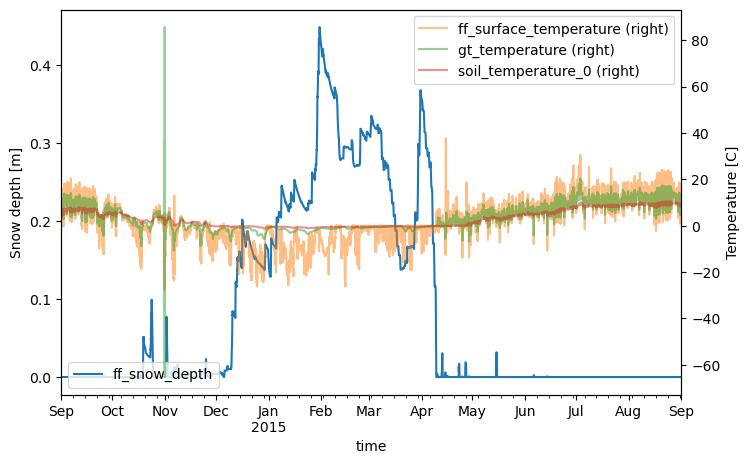

In [5]:
ax = results_df[['ff_snow_depth', 
            #'ff_snow_water_equivalent'
            ]].plot(figsize=(8, 5))

ax1 = results_df[['ff_surface_temperature',
                 'gt_temperature',
                 'soil_temperature_0']].plot(ax=ax, alpha=0.5, secondary_y=True)

ax.legend(loc='lower left')
ax1.legend(loc='upper right')
ax.set_ylabel('Snow depth [m]')
ax1.set_ylabel('Temperature [C]')
#filename = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/pyAPES_figs/stability_2.png'
#plt.savefig(filename, dpi=300, bbox_inches="tight")

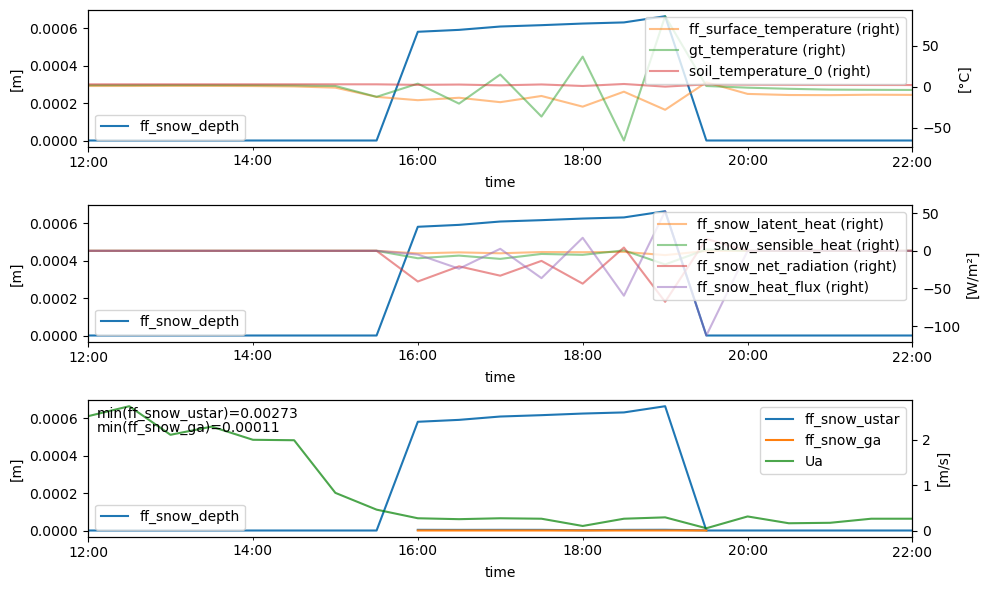

In [6]:
window = slice('2014-10-31 12:00', '2014-10-31 22:00')

fig, axes = plt.subplots(3, 1, figsize=(10, 6))  # 3 rows, 1 column

# --- First subplot: Snow depth and temperatures ---
ax = results_df[window][['ff_snow_depth']].plot(ax=axes[0], legend=False)
ax1 = results_df[window][['ff_surface_temperature',
                           'gt_temperature',
                           'soil_temperature_0']].plot(ax=ax, alpha=0.5, secondary_y=True, legend=False)
# Add forcing['Tair'] to the same secondary axis
#forcing[window]['Tair'].plot(ax=ax1, color='purple', alpha=0.7, label='Tair')

ax.set_ylabel('[m]')
ax1.set_ylabel('[°C]')
ax.legend(loc='lower left')
ax1.legend(loc='upper right')

# --- Second subplot: Ground temperature and heat fluxes ---
ax = results_df[window][['ff_snow_depth']].plot(ax=axes[1], legend=False)
ax1 = results_df[window][['ff_snow_latent_heat',
                           'ff_snow_sensible_heat',
                           'ff_snow_net_radiation',
                           'ff_snow_heat_flux']].plot(ax=ax, alpha=0.5, secondary_y=True, legend=False)

ax.set_ylabel('[m]')
ax1.set_ylabel('[W/m²]')
ax.legend(loc='lower left')
ax1.legend(loc='upper right')

# --- Third subplot: Snow depth, ustar, and wind speed ---
ax = results_df[window][['ff_snow_depth']].plot(ax=axes[2], legend=False)
ax1 = ax.twinx()  # create secondary y-axis
results_df[window][['ff_snow_ustar', 'ff_snow_ga']].plot(ax=ax1, secondary_y=False, legend=False)
forcing[window]['U'].plot(ax=ax1, color='green', alpha=0.7, label='U')

# Find the minimum value
min_val_1 = results_df[window]['ff_snow_ustar'].min()
min_val_2 = results_df[window]['ff_snow_ga'].min()

# Plot the text in the upper-left corner of ax1 (secondary y-axis)
ax1.text(0.01, 0.95, f"min(ff_snow_ustar)={results_df[window]['ff_snow_ustar'].min():.5f}",
         transform=ax1.transAxes,  # use axes coordinates
         verticalalignment='top')
ax1.text(0.01, 0.85, f"min(ff_snow_ga)={results_df[window]['ff_snow_ga'].min():.5f}",
         transform=ax1.transAxes,  # use axes coordinates
         verticalalignment='top')

ax.set_ylabel('[m]')
ax1.set_ylabel('[m/s]')
ax.legend(loc='lower left')
ax1.legend(['ff_snow_ustar', 'ff_snow_ga', 'Ua'], loc='upper right')

plt.tight_layout()
#filename = r'/Users/jpnousu/Library/CloudStorage/OneDrive-Valtion/pyAPES_figs/stability_29_9.png'
#plt.savefig(filename, dpi=300, bbox_inches="tight")
plt.show()
